In [21]:
from IPython.display import Image

## basics

- self attention
$$
\text{Attention}(Q, K, V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$
- 加速了推理过程，尤其是 GPT、LLama 这样的 autoregressive 模型；
- KV cache or Key-Value cache
- The Key and Value states are used for calculating the scaled dot-product attention.
    - KV caching occurs during multiple token generation steps and only happens in the decoder (i.e., in decoder-only models like GPT, or in the decoder part of encoder-decoder models like T5). 
    - Models like BERT are not generative and therefore do not have KV caching.

###  CLM (causal language model) task

- NTP (next token prediction) training: 
    - Input: [SOS] Love that can quickly seize the gentle heart
    - Target: Love that can quickly seize the gentle heart [EOS]
- NTP inference
    - SOS: start of sentence
    - EOS: end of sentence
|     | Input                                              | Output                                             |
|-----|:---------------------------------------------------|:---------------------------------------------------|
| t=1 | [SOS]                                              | Love                                               |
| t=2 | [SOS] Love                                         | Love that                                          |
| t=3 | [SOS] Love that                                    | Love that can                                      |
| t=4 | [SOS] Love that can                                | Love that can quickly                              |
| t=5 | [SOS] Love that can quickly                        | Love that can quickly seize                        |
| t=6 | [SOS] Love that can quickly seize                  | Love that can quickly seize the                    |
| t=7 | [SOS] Love that can quickly seize the              | Love that can quickly seize the gentle             |
| t=8 | [SOS] Love that can quickly seize the gentle       | Love that can quickly seize the gentle heart       |
| t=9 | [SOS] Love that can quickly seize the gentle heart | Love that can quickly seize the gentle heart [EOS] |

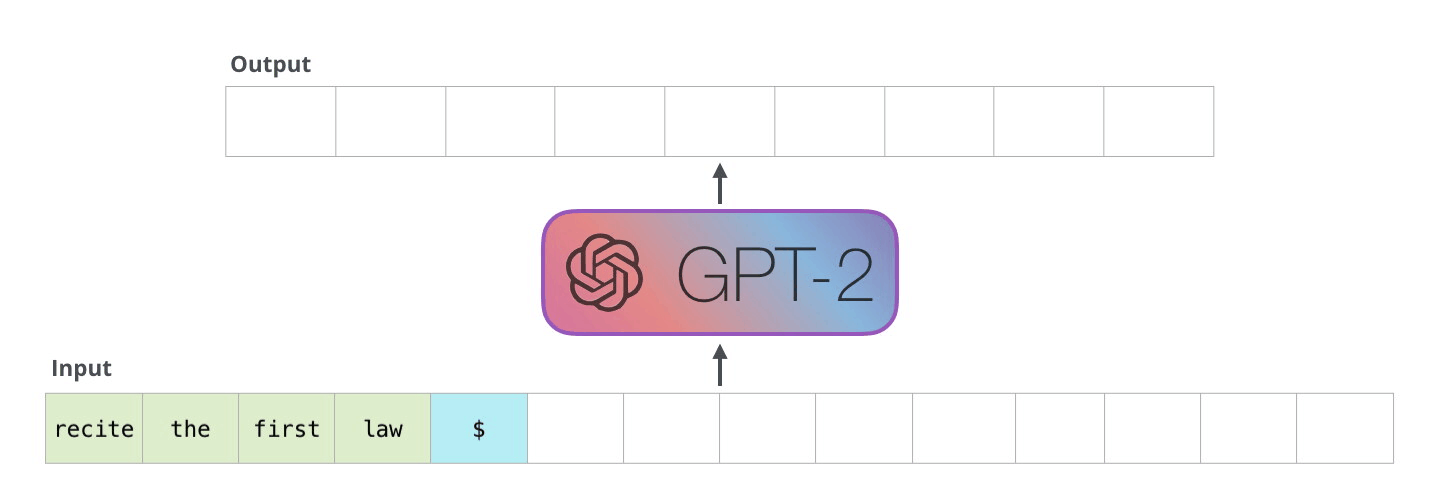

In [26]:
Image('../imgs/gpt-2-autoregression-2.gif', width=700)

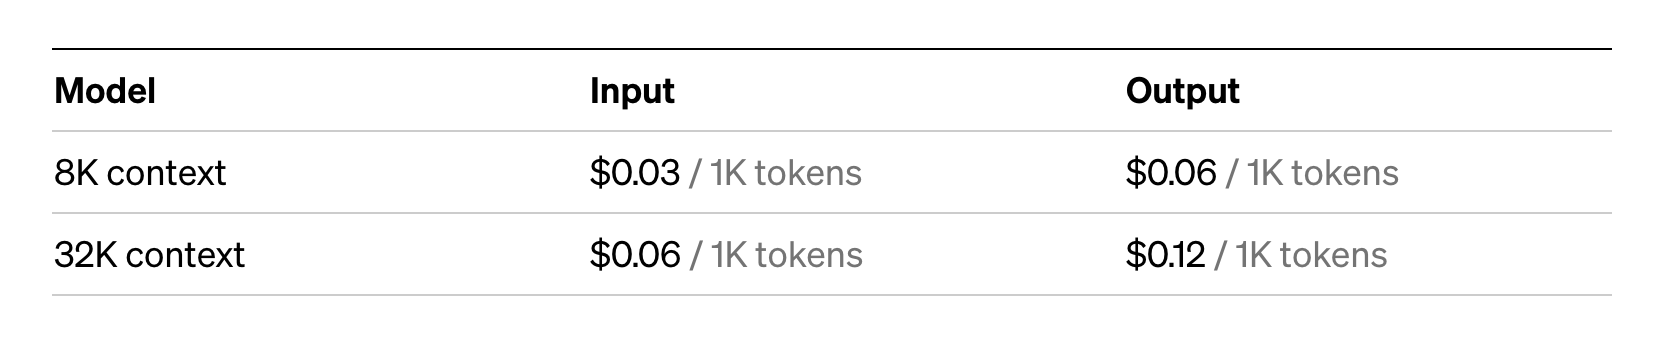

In [4]:
Image('../imgs/gpt4-price.png', width=600)

### qkv

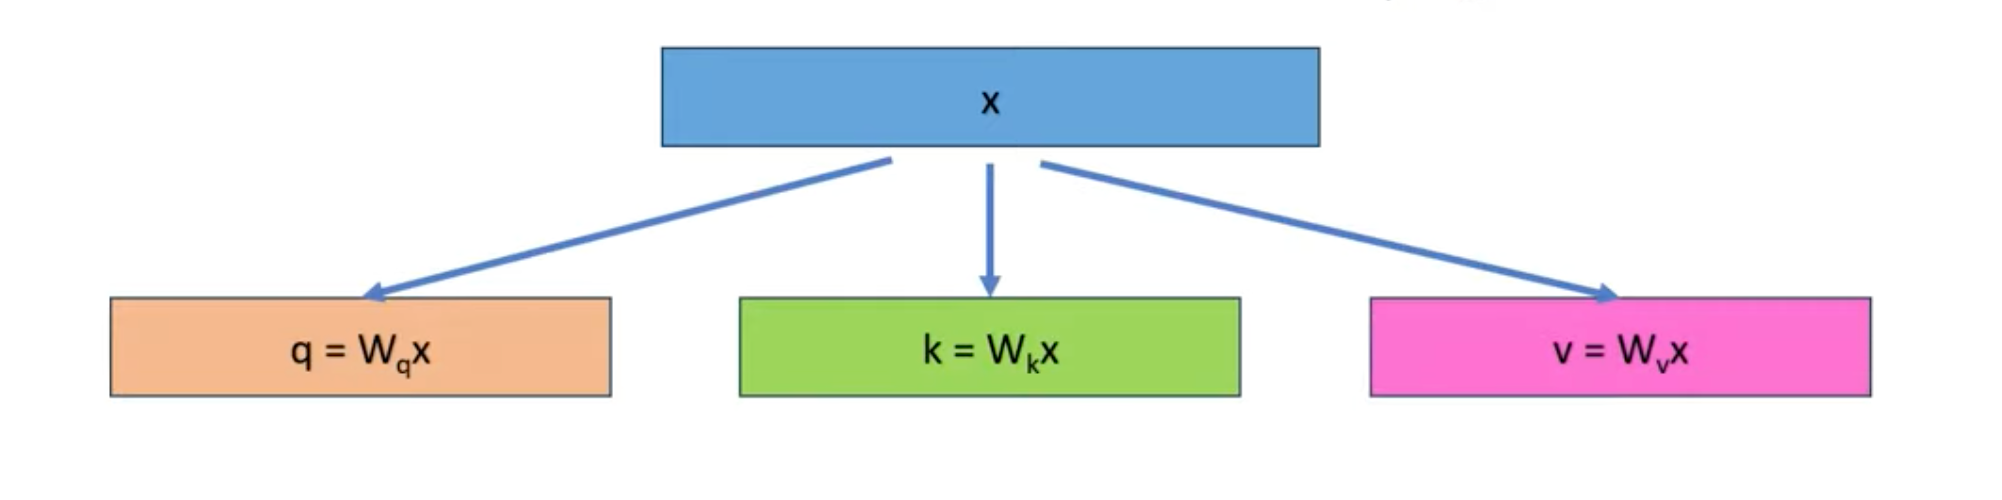

In [6]:
Image('../imgs/qkv.png', width=600)

- x: token embedding
- $W_{q,k,v}$: learned from data

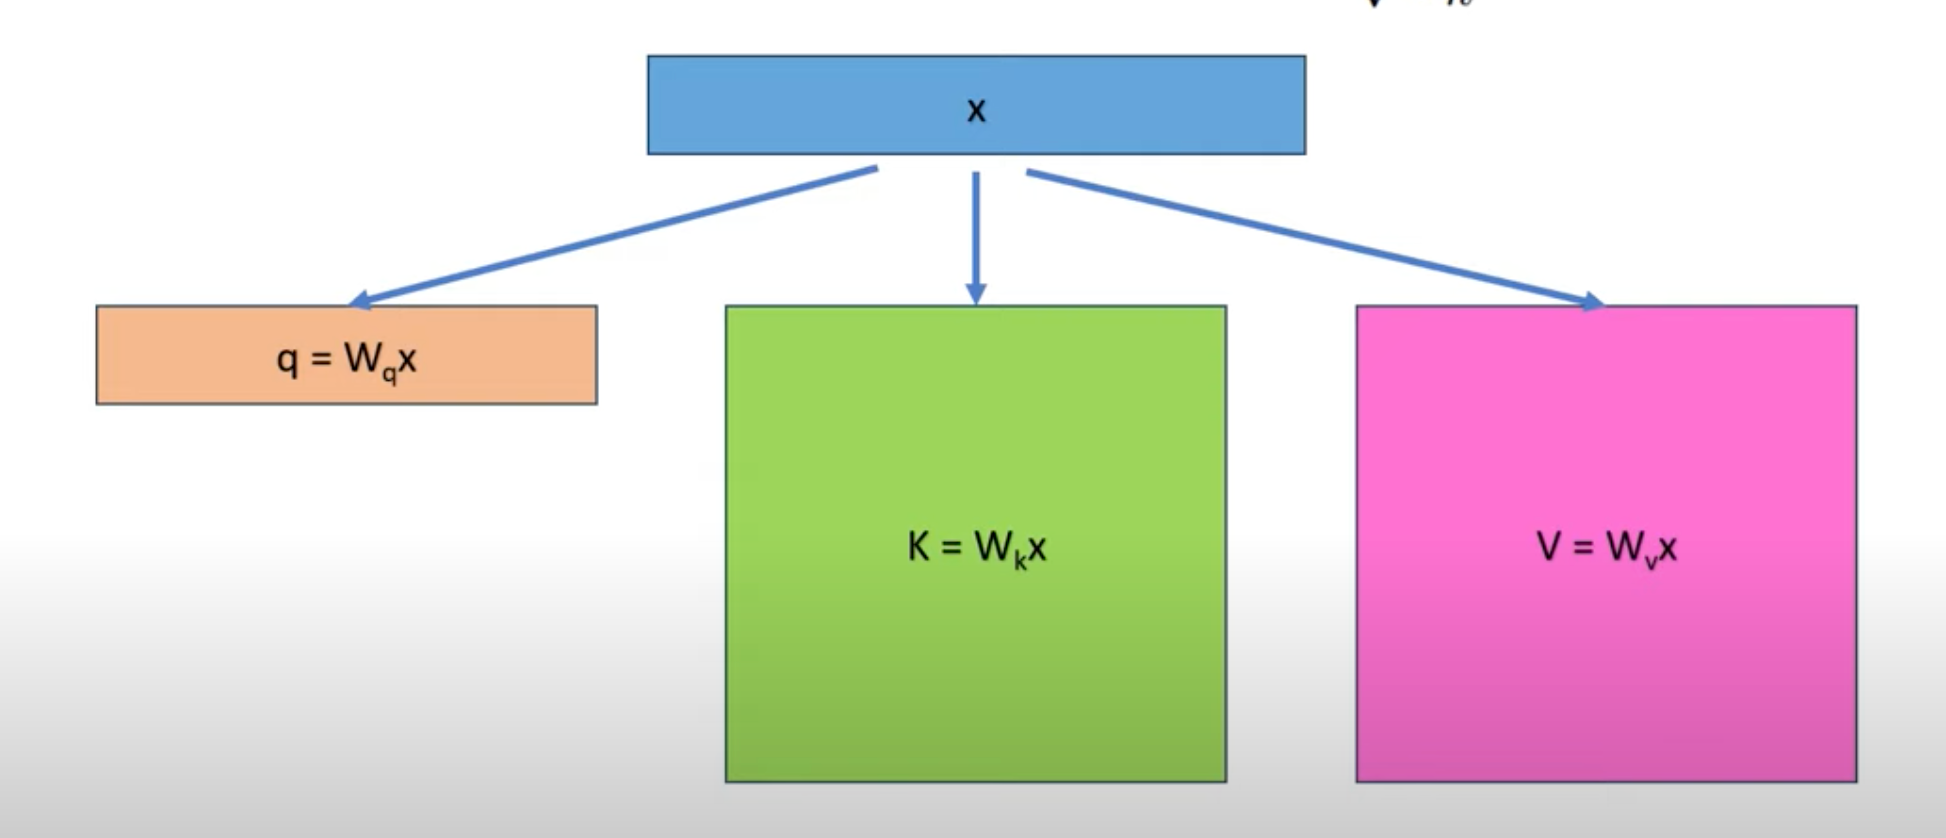

In [7]:
Image('../imgs/decoding-qkv.png', width=600)

- decoding 阶段，q 仍然只是一个 vector
    - K, V：却是 matrix
    
- q(query)：new token in this decoder step
- K(Key)、V(Value)
    - K(Key): previous context that model should attend
    - V(Value): weighted sum over previous context

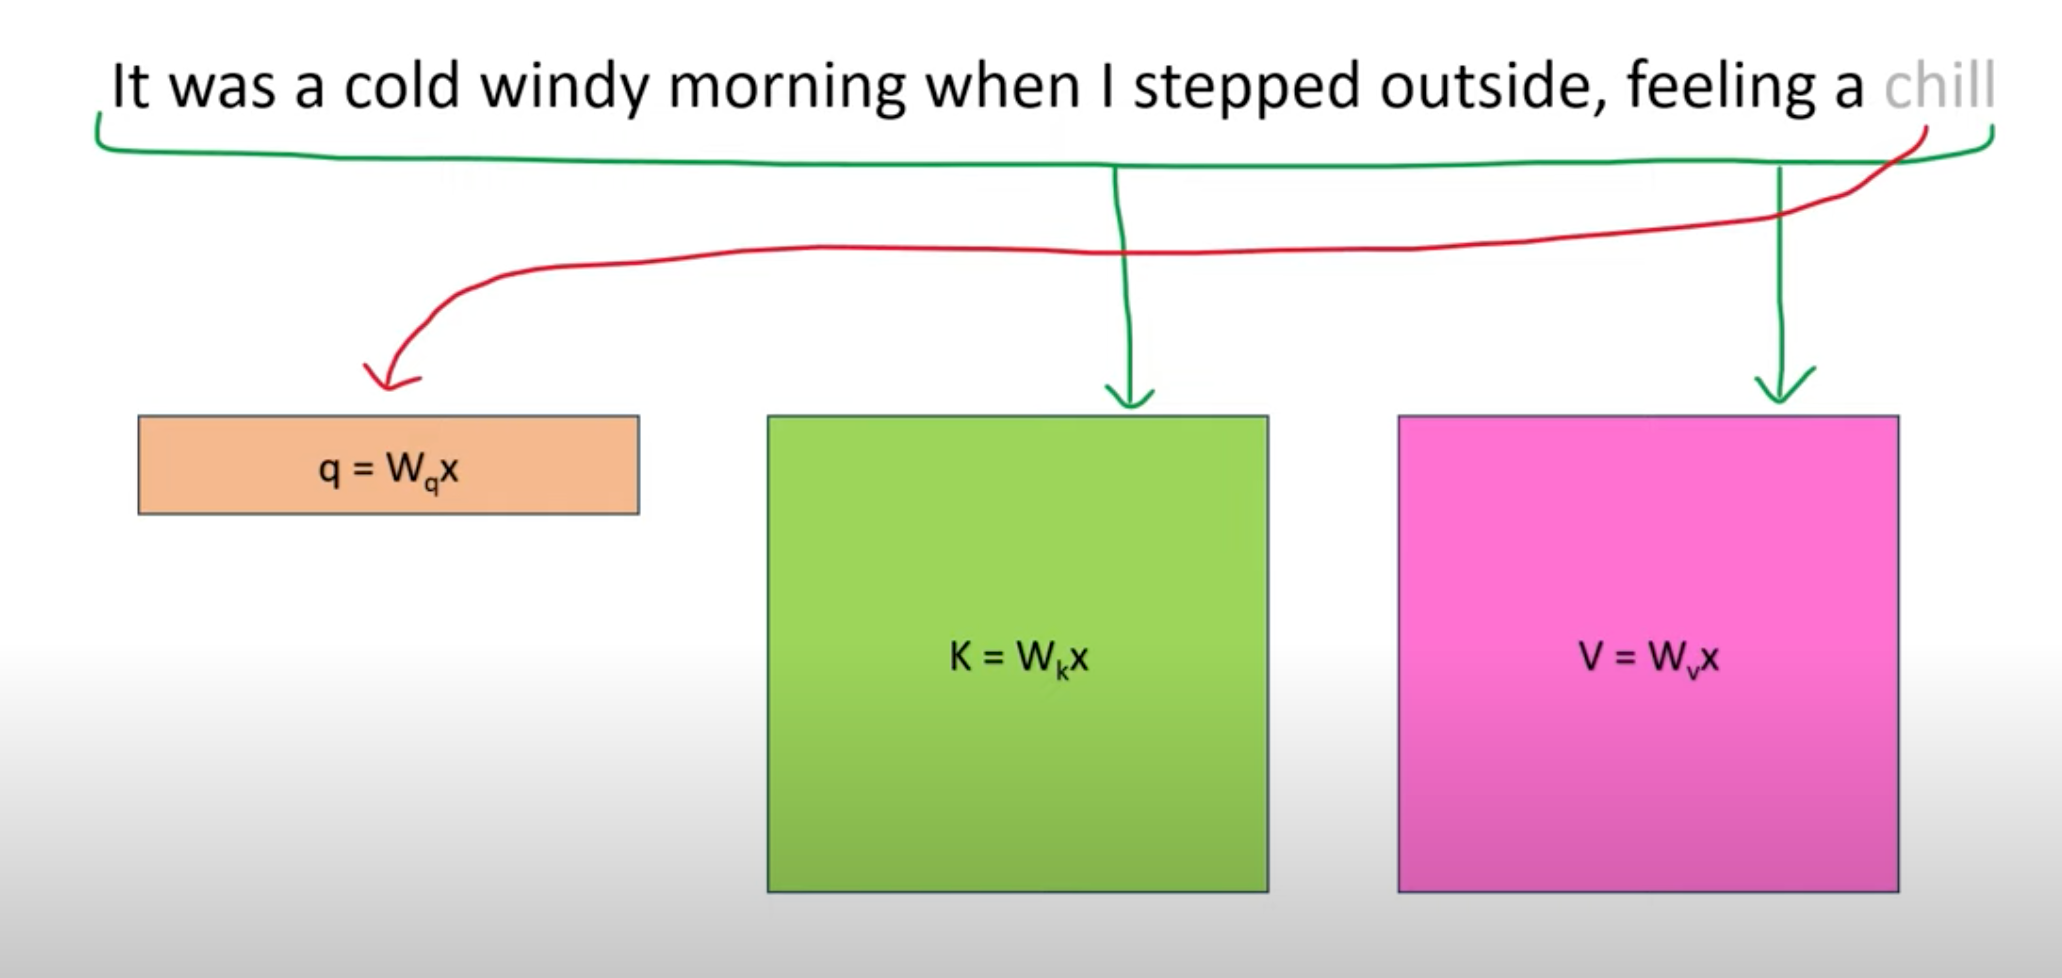

In [27]:
Image('../imgs/kvmatrices.png', width=600)

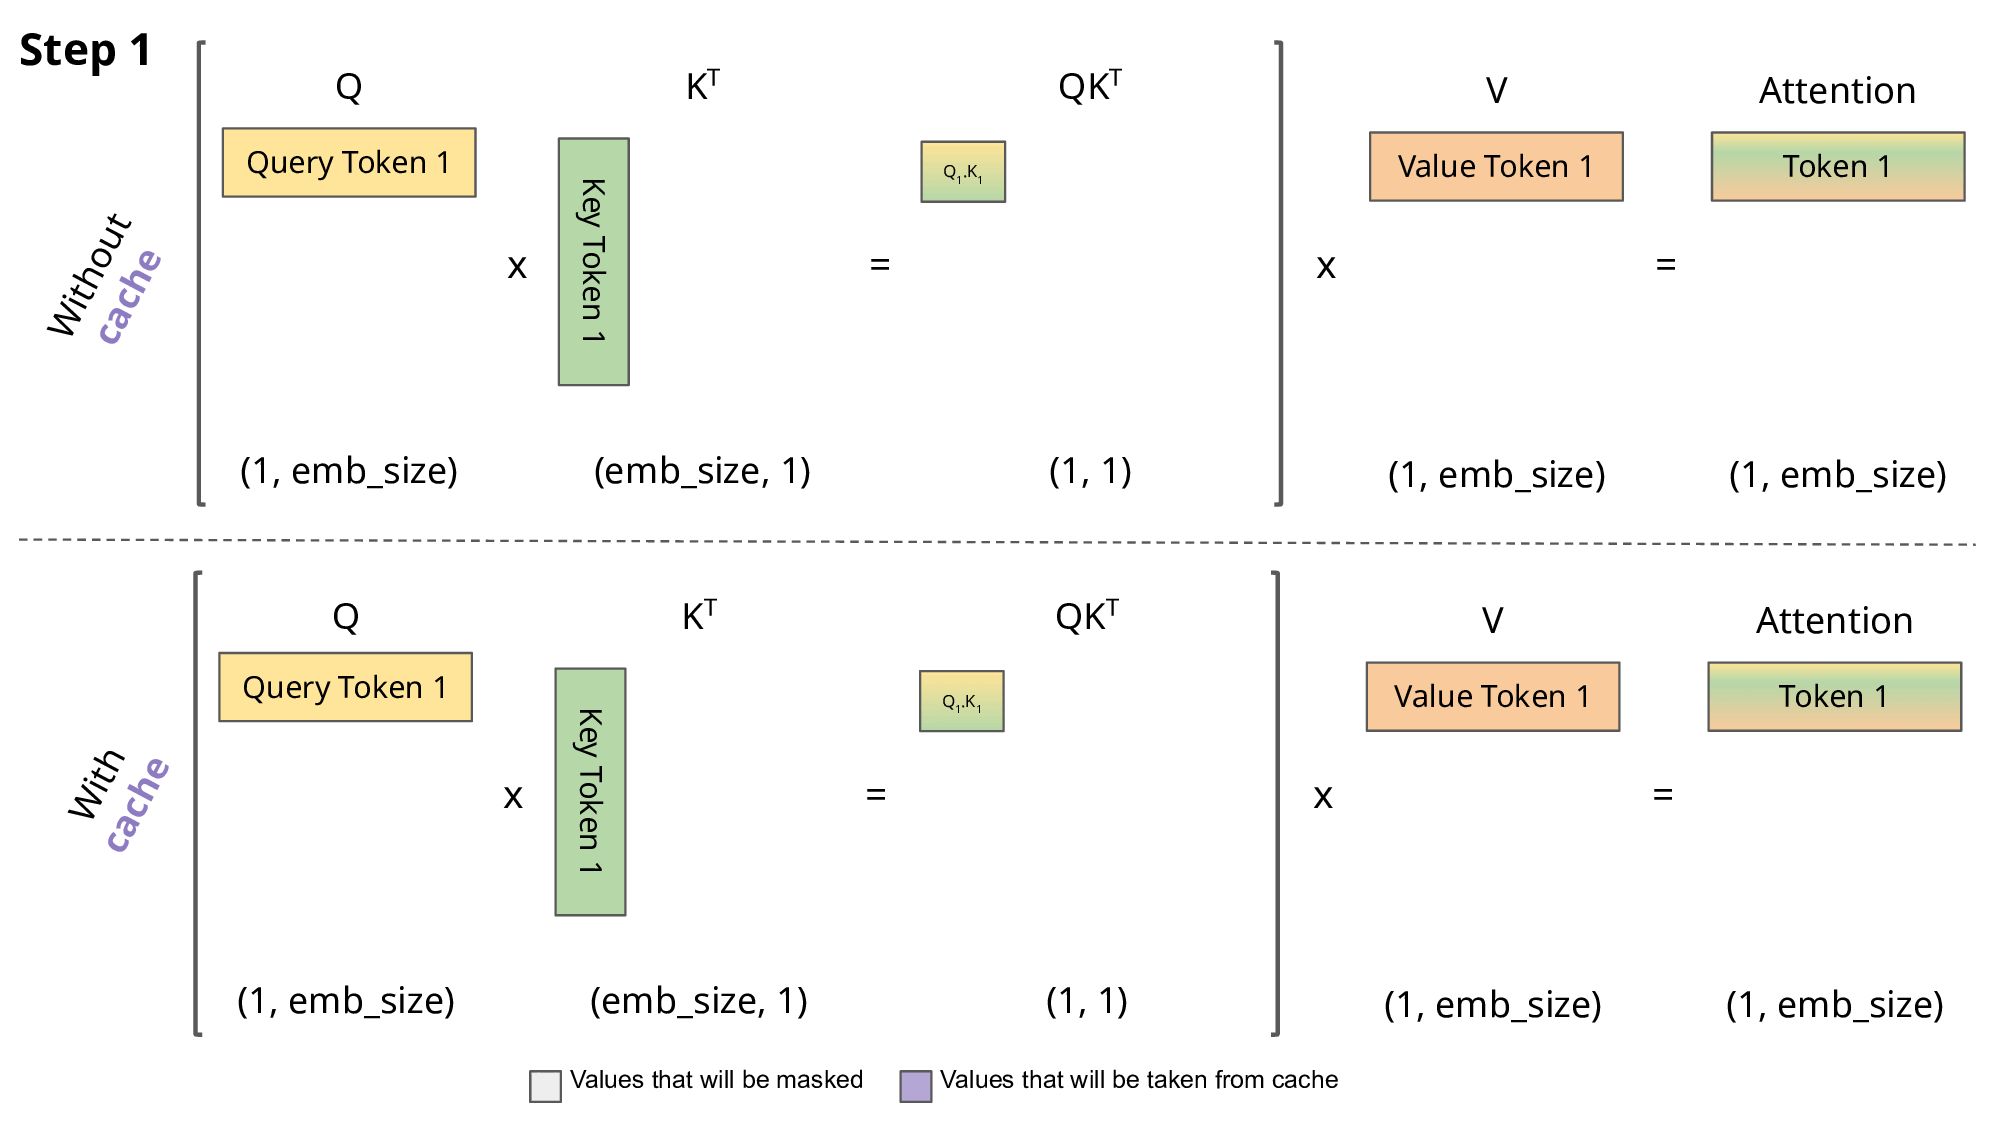

In [28]:
Image('../imgs/kv-cache.gif', width=900)

## llama2

| **model** | **heads** | **layers** | **dim** | **head_dim** |
|-----------|-----------|------------|---------|--------------|
| 7b        | 32        | 32         | 4096    | 4096/32      |
| 13b       | 40        | 40         | 5120    | 5120/40      |
| 70b       | 64        | 80         | 8192    | 8192/64      |

In [8]:
from sentencepiece import SentencePieceProcessor
sp_model = SentencePieceProcessor(model_file='./tokenizer.model')

In [9]:
prompt = 'I believe the meaning of life is'
[sp_model.bos_id(), *sp_model.encode(prompt)]

[1, 306, 4658, 278, 6593, 310, 2834, 338]

```
class Attention(nn.Module):
    """Multi-head attention module."""
    def __init__(self, args: ModelArgs):
    
        self.wq = ColumnParallelLinear(args.dim, args.n_heads * self.head_dim)
        self.wk = ColumnParallelLinear(args.dim, self.n_kv_heads * self.head_dim)
        self.wv = ColumnParallelLinear(args.dim, self.n_kv_heads * self.head_dim)
        self.wo = RowParallelLinear(args.n_heads * self.head_dim, args.dim)
        
        
        # [8, 1024, 32, 128]
        self.cache_k = torch.zeros(
            (
                args.max_batch_size,    # 8
                args.max_seq_len,       # 1024, 不断地在这个维度上append keys
                self.n_local_kv_heads,  # 32
                self.head_dim,          # 128
            )
        ).cuda()
        
        #  [8, 1024, 32, 128]
        self.cache_v = torch.zeros(
            (
                args.max_batch_size,    # 8
                args.max_seq_len,       # 1024, 不断地在这个维度上append values
                self.n_local_kv_heads,  # 32
                self.head_dim,          # 128
            )
        ).cuda()
    
    def forward(
        self,
        x: torch.Tensor,
        start_pos: int,
        freqs_cis: torch.Tensor,
        mask: Optional[torch.Tensor],
    ):
        xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)
        
        xq = xq.view(bsz, seqlen, self.n_local_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)

        xq, xk = apply_rotary_emb(xq, xk, freqs_cis=freqs_cis)

        self.cache_k = self.cache_k.to(xq)
        self.cache_v = self.cache_v.to(xq)
        
        
        self.cache_k[:bsz, start_pos : start_pos + seqlen] = xk
        self.cache_v[:bsz, start_pos : start_pos + seqlen] = xv
        
        # 这里在复用之前的计算, all_past
        keys = self.cache_k[:bsz, : start_pos + seqlen]
        values = self.cache_v[:bsz, : start_pos + seqlen]
        
```

## transformers 库

In [14]:
import os
os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"

In [15]:
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)

In [13]:
tokenizer

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True)

In [19]:
for use_cache in (True, False):
    times = []
    for _ in range(10):  # measuring 10 generations
        start = time.time()
        model.generate(**tokenizer("What is KV caching?", return_tensors="pt").to(device), 
                       use_cache=use_cache, 
                       max_new_tokens=1000)
        times.append(time.time() - start)
    mu = round(np.mean(times), 3)
    std = round(np.std(times), 3)
    print(f"{'with' if use_cache else 'without'} KV caching: {mu} +- {std} seconds")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


with KV caching: 6.636 +- 0.023 seconds


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


without KV caching: 8.283 +- 0.049 seconds
